In [53]:
!pip install -U fsds_100719
import IPython.display as disp
disp.clear_output()
print('testing')

testing


In [54]:
# Shortcut import of 
# import pandas as pd, numpy as np, etc...
import fsds_100719 as fs
from fsds_100719.imports import *

**Taking a preview of the data**

In [55]:
# Ignore pink warnings 
import warnings
warnings.filterwarnings('ignore')

# Allow for a large # of columns
pd.set_option('display.max_columns',0)
# pd.set_option('display.max_rows','')

df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


*Here, we see several variables, which upon initial inspection, I see as four main types:* 
1. Items we can directly control via renovations or timing we put home on market:
    ['bedrooms', 'date', 'bathrooms', 'sqft_living', 'floors', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_renovated']
2. Items we cannot control, but can help us in deciding the right homes/areas to look for our flip:
    ['sqft_lot', 'waterfront', 'view', 'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
3. Item we are using as our target:
    'price'
4. Variables we can drop:
    'id' --> due to us just wanting to see patterns, and it does not matter how we reference the sold home
    'view' --> we are just flipping. Marketing/understanding the complicated selling process will be left to the realtors


In [56]:
df.drop(columns=['id', 'view'], inplace=True)                                         #dropping id, view columns
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


# SCRUB

In [57]:
for col in df.columns:
    print('----'*5)
    print(df[col].name)
    na = df[col].isna().sum()
    if na > 0:
        print(f'Number of NaNs: {na}\n')
    print(f'Most common values are:\n{df[col].value_counts()}')
    #find which ones have NaN values & weird values

--------------------
date
Most common values are:
6/23/2014    142
6/25/2014    131
6/26/2014    131
7/8/2014     127
4/27/2015    126
            ... 
11/2/2014      1
5/27/2015      1
1/17/2015      1
1/31/2015      1
2/15/2015      1
Name: date, Length: 372, dtype: int64
--------------------
price
Most common values are:
350000.0    172
450000.0    172
550000.0    159
500000.0    152
425000.0    150
           ... 
870515.0      1
336950.0      1
386100.0      1
176250.0      1
884744.0      1
Name: price, Length: 3622, dtype: int64
--------------------
bedrooms
Most common values are:
3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64
--------------------
bathrooms
Most common values are:
2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75  

*Waterfront* is missing over 10% of values. With it being whether a house has a view of the water, it's not exactly a simple variable to check up. One would literally have to see the view from the house. And since only 146 out of over 21K homes actually have a view, seems like a pointless column. Will drop

In [58]:
df.drop(columns='waterfront', inplace=True)
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,10/13/2014,221900.0,3,1.00,1180,5650,1.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,12/9/2014,538000.0,3,2.25,2570,7242,2.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,2/25/2015,180000.0,2,1.00,770,10000,1.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,12/9/2014,604000.0,4,3.00,1960,5000,1.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,2/18/2015,510000.0,3,2.00,1680,8080,1.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


*sqft_basement* weirdly has '?' has value. Seeing as how we have a sqft_living for all the area of the house, and sqft_above, which measures everything outside of basement, makes sense to just set basement = total - above

In [59]:
df['sqft_basement'] = df['sqft_living'] - df['sqft_above']
df.sqft_basement.value_counts()

0       13110
600       221
700       218
500       214
800       206
        ...  
792         1
2590        1
935         1
2390        1
248         1
Name: sqft_basement, Length: 306, dtype: int64

*fix yr_renovated* has NaN's as well as 0's. If there is a NaN/0, I would assume no renovations were done, or at least none done legally with permits. In either situation, you can't promise a home has been renovated. So in those cases, the new value in this column is the yr the home was built. With that, the name of column is last_constructed to better reflect what it represents now

In [60]:
df['yr_renovated'].fillna(value=df.yr_built, inplace=True)  
df.loc[df['yr_renovated'] == 0, 'yr_renovated'] = df['yr_built']
df.rename(columns = {'yr_renovated': 'last_constructed'}, inplace=True)
df.last_constructed = df.last_constructed.astype('int64')     #it's a yr, shouldn't be a float
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,last_constructed,zipcode,lat,long,sqft_living15,sqft_lot15
0,10/13/2014,221900.0,3,1.00,1180,5650,1.0,3,7,1180,0,1955,1955,98178,47.5112,-122.257,1340,5650
1,12/9/2014,538000.0,3,2.25,2570,7242,2.0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,2/25/2015,180000.0,2,1.00,770,10000,1.0,3,6,770,0,1933,1933,98028,47.7379,-122.233,2720,8062
3,12/9/2014,604000.0,4,3.00,1960,5000,1.0,5,7,1050,910,1965,1965,98136,47.5208,-122.393,1360,5000
4,2/18/2015,510000.0,3,2.00,1680,8080,1.0,3,8,1680,0,1987,1987,98074,47.6168,-122.045,1800,7503


In [61]:
df.date = pd.to_datetime(df.date).dt.month
df.rename(columns = {'date': 'month_sold'}, inplace=True)

was having trouble w/ getting scatter plots of elements since date is not "graphable" in its form. Decided to change it to datetime object, so I can easily get the month. Really unlikely to get a home sold on the same day, so as it was, date was a horrible feature. One could possibly sell a home in a month that seems like prime-time to sell. Depending on models, may turn this into seasons of yr instead of months.

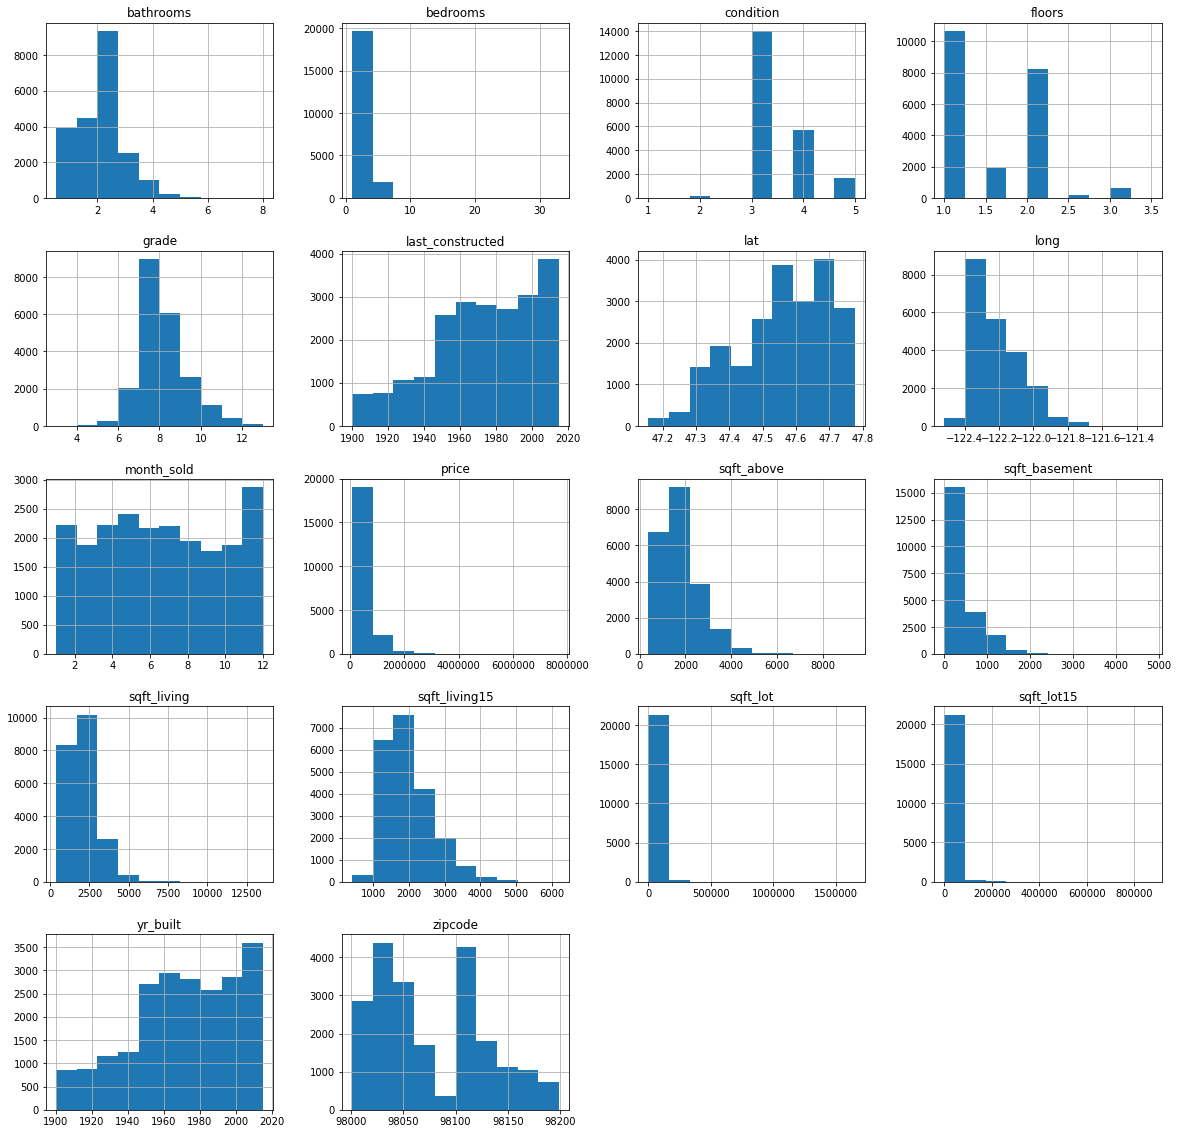

In [62]:
df.hist(figsize=(20,20));

*Due to the above scatterplots, can infer the following are categorical: 
    ['month_sold', 'floors', 'condition', 'grade', 'zipcode']
 Will deal with them after getting hist plots.*

*Certain outlier(s) having HUGE affects on my skews for 'bedrooms', 'sqft_living', 'sqft_lot', 'sqft_lot15'. Would appear to be an exceptionally huge home(s). Time to investigate!*

In [63]:
df.describe()

,month_sold,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,last_constructed,zipcode,lat,long,sqft_living15,sqft_lot15
count,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,6.573969,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,3.409825,7.657915,1788.596842,291.725008,1970.999676,1972.945131,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,3.115061,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.650546,1.173200,827.759761,442.667800,29.375234,28.945393,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000000,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,1900.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,4.000000,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,1954.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,6.000000,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,3.000000,7.000000,1560.000000,0.000000,1975.000000,1977.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,9.000000,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,1999.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,12.000000,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [64]:
df[df['bedrooms']>=10]

,month_sold,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,last_constructed,zipcode,lat,long,sqft_living15,sqft_lot15
8748,8,520000.0,11,3.00,3000,4960,2.0,3,7,2400,600,1918,1999,98106,47.5560,-122.363,1420,4960
13301,8,1150000.0,10,5.25,4590,10920,1.0,3,9,2500,2090,2008,2008,98004,47.5861,-122.113,2730,10400
15147,10,650000.0,10,2.00,3610,11914,2.0,4,7,3010,600,1958,1958,98006,47.5705,-122.175,2040,11914
15856,6,640000.0,33,1.75,1620,6000,1.0,5,7,1040,580,1947,1947,98103,47.6878,-122.331,1330,4700
19239,12,660000.0,10,3.00,2920,3745,2.0,4,7,1860,1060,1913,1913,98105,47.6635,-122.320,1810,3745


*We have just 5 homes with 10+ bedrooms. Will drop them not only due to skewness, but also I do not want to renovate that many homes*

In [65]:
df.drop(df[df['bedrooms']>=10].index, inplace=True)
df[df['bedrooms']>=10]

,month_sold,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,last_constructed,zipcode,lat,long,sqft_living15,sqft_lot15


In [66]:
df[df['sqft_lot']>21780]

,month_sold,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,last_constructed,zipcode,lat,long,sqft_living15,sqft_lot15
5,5,1230000.0,4,4.50,5420,101930,1.0,3,11,3890,1530,2001,2001,98053,47.6561,-122.005,4760,101930
21,8,2000000.0,3,2.75,3050,44867,1.0,3,9,2330,720,1968,1968,98040,47.5316,-122.233,4110,20336
36,5,550000.0,4,1.00,1660,34848,1.0,1,5,930,730,1933,1933,98052,47.6621,-122.132,2160,11467
41,8,775000.0,4,2.25,4220,24186,1.0,3,8,2600,1620,1984,1984,98166,47.4450,-122.347,2410,30617
49,3,1350000.0,3,2.50,2753,65005,1.0,5,9,2165,588,1953,1953,98070,47.4041,-122.451,2680,72513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21478,7,915000.0,3,4.50,3850,62726,2.0,3,10,3120,730,2013,2013,98053,47.6735,-122.058,2630,46609
21490,5,2240000.0,5,6.50,7270,130017,2.0,3,12,6420,850,2010,2010,98027,47.5371,-121.982,1800,44890
21504,8,1410000.0,4,4.00,4920,50621,2.0,3,10,4280,640,2012,2012,98053,47.6575,-122.006,4920,74052
21509,11,1450000.0,4,3.50,4300,108865,2.0,3,11,4300,0,2014,2014,98074,47.6258,-122.005,4650,107498


*These are homes with lots bigger than half acre(21780 sqft). Since I would have to pay for landscaping, and I am not too familiar with doing so, will drop these huge lot-homes. Also, this homes are skewing my data, which can affect my model*

In [67]:
df.drop(df[df['sqft_lot']>=21780].index, inplace=True)
df[df['sqft_lot']>=21780]

,month_sold,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,last_constructed,zipcode,lat,long,sqft_living15,sqft_lot15


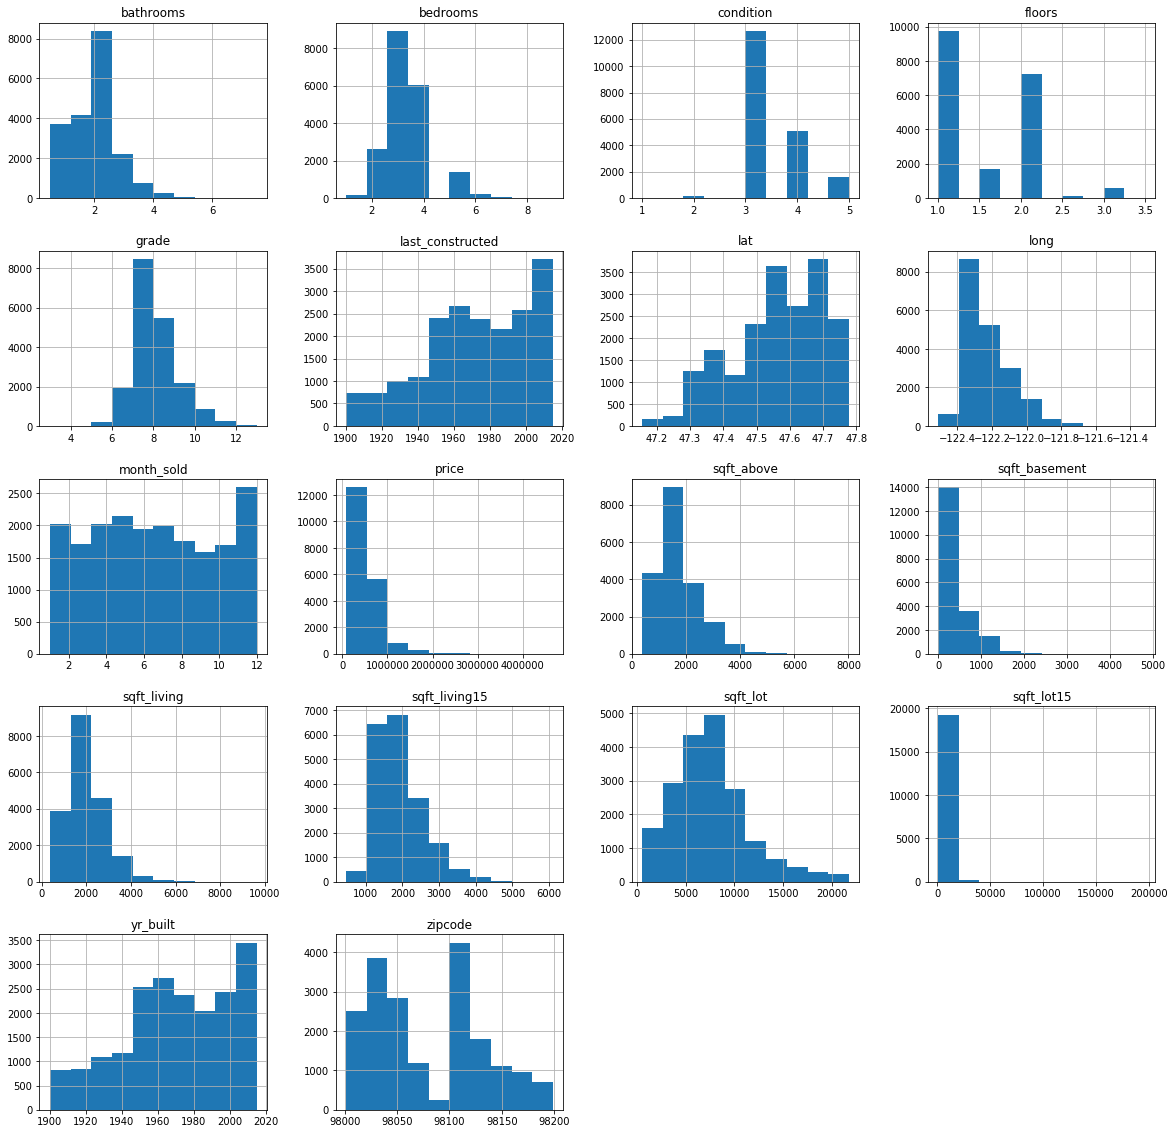

In [68]:
df.hist(figsize=(20,20));

In [69]:
df.corrwith(df['sqft_lot'])

month_sold         -0.005005
price               0.156105
bedrooms            0.214265
bathrooms           0.057374
sqft_living         0.284117
sqft_lot            1.000000
floors             -0.290519
condition           0.109256
grade               0.154121
sqft_above          0.238968
sqft_basement       0.137550
yr_built           -0.021215
last_constructed   -0.029397
zipcode            -0.259312
lat                -0.120555
long                0.240146
sqft_living15       0.322696
sqft_lot15          0.713697
dtype: float64

*Figured sqft_lot15 would be strongly correlated with sqft_lot, which it does have a .72 corr value. Will drop those homes as well since in real estate, you do not want your home to be vastly different from others. If someone is looking in a neighborhood with giant lots, they may be disappointed with the smaller lot I am working with.*

In [70]:
df.drop(df[df['sqft_lot15']>=21780].index, inplace=True)

*will do the same with homes over 1000 sqft larger than the avg American home size of 2700sqft.*

In [71]:
df.drop(df[df['sqft_living']>3700].index, inplace=True)
df.drop(df[df['sqft_living15']>3700].index, inplace=True)

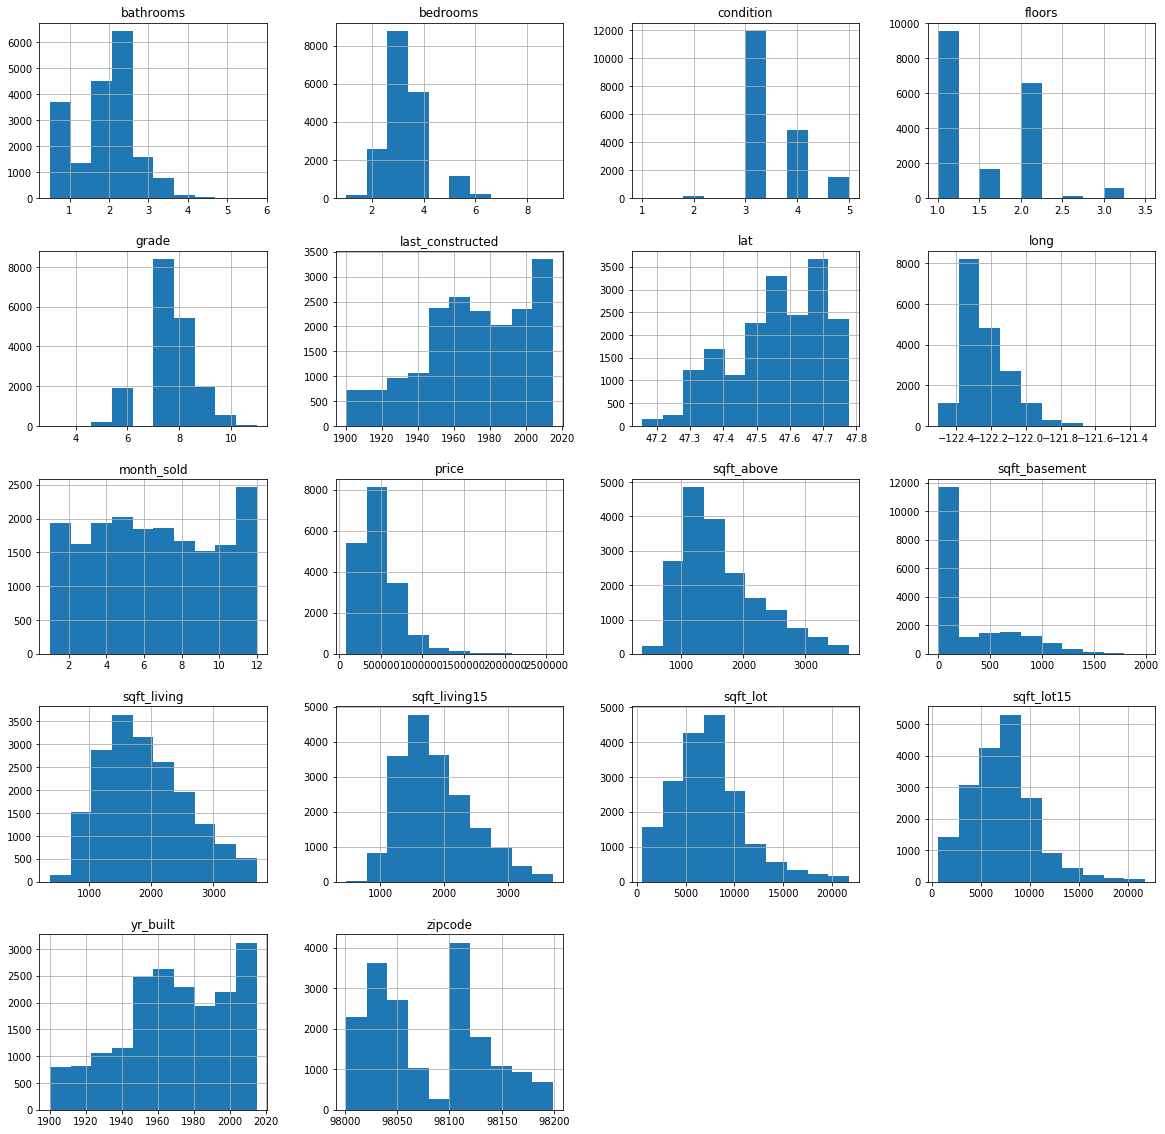

In [72]:
df.hist(figsize=(20,20));

In [73]:
price_corr = df.corrwith(df['price'])
price_corr.abs().sort_values(ascending=False)

price               1.000000
grade               0.600265
sqft_living         0.584175
sqft_living15       0.518544
sqft_above          0.462514
bathrooms           0.405424
lat                 0.404888
bedrooms            0.266657
sqft_basement       0.258925
floors              0.235849
condition           0.071562
sqft_lot            0.030844
sqft_lot15          0.029064
yr_built            0.025972
long                0.025226
last_constructed    0.024910
month_sold          0.020093
zipcode             0.010494
dtype: float64

*price is most correlated to ['grade', 'sqft_living','sqft_living15', 'sqft_above', 'bathrooms']*

In [112]:
corr = features.corr().abs()
corr[corr>.7]

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,last_constructed,lat,long,sqft_living15
bedrooms,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bathrooms,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sqft_living,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.724545
sqft_lot,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
floors,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
yr_built,NaN,NaN,NaN,NaN,NaN,1.000000,0.928383,NaN,NaN,NaN
last_constructed,NaN,NaN,NaN,NaN,NaN,0.928383,1.000000,NaN,NaN,NaN
lat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
long,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
sqft_living15,NaN,NaN,0.724545,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


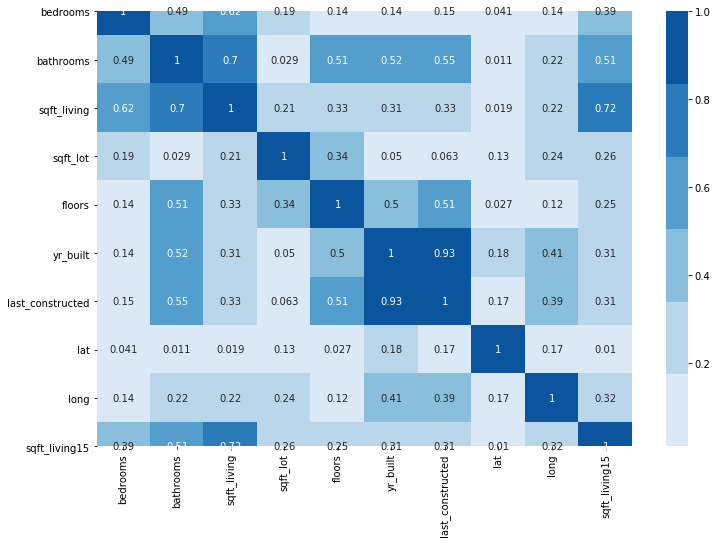

In [114]:
features = df.drop(columns='price')
corr = features.corr().abs()
plt.figure(figsize=(12,8))
sns.heatmap(data=corr, annot=True, cmap=sns.color_palette('Blues'));

*sqft_living has most colinearity. But is also a top item correlated to price. To fix this, I will drop sqft_above, and sq_ft below. Total living space is more of a measure people pay attention to then splitting. Sqft_lot is strongly correlated to sqft_lot15, so I will drop sqft_lot15 since sqft_lot is something most people can easily understand. Plus with the high correlation, this means lot sizes are similar to those of their neighbors already.*

In [75]:
features.drop(columns=['sqft_above','sqft_basement', 'sqft_lot15'], inplace=True)
df.drop(columns=['sqft_above','sqft_basement', 'sqft_lot15'], inplace=True)

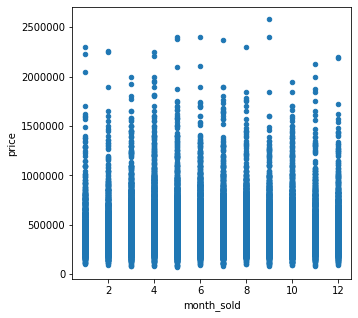

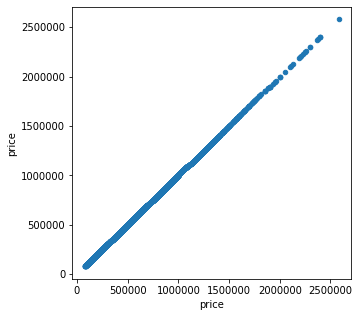

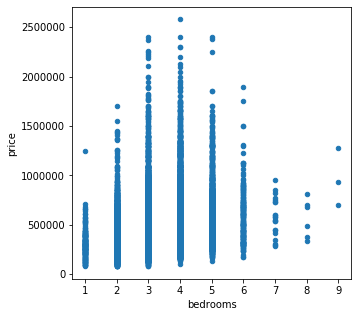

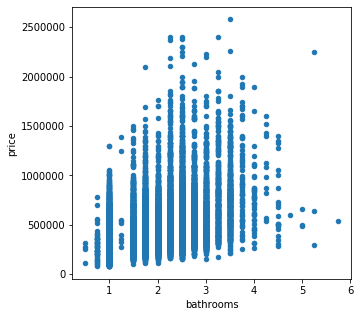

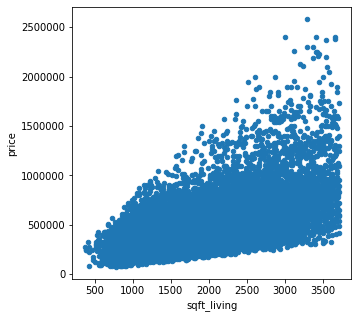

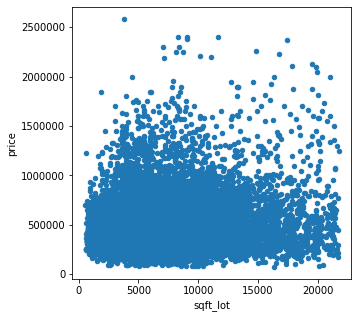

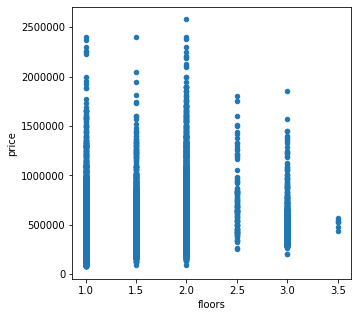

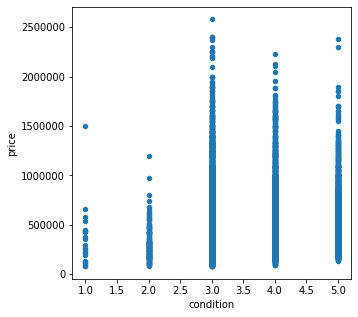

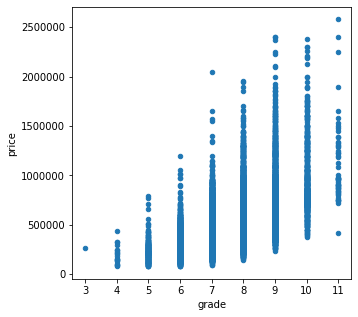

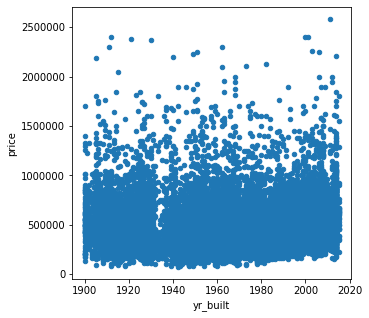

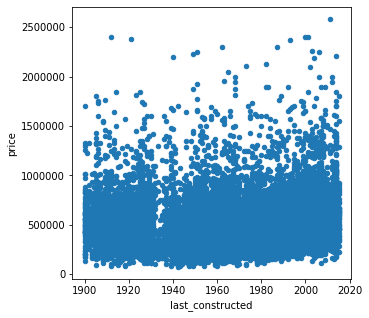

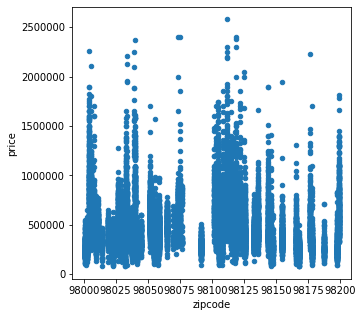

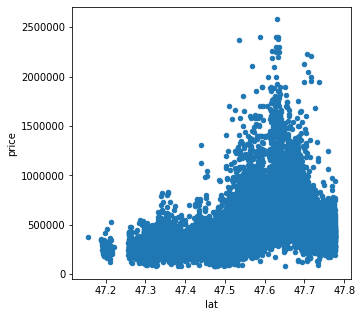

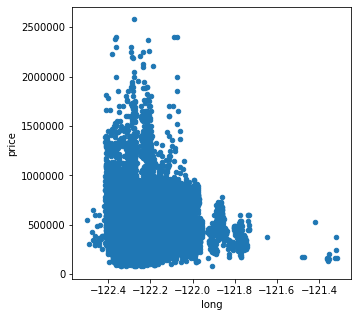

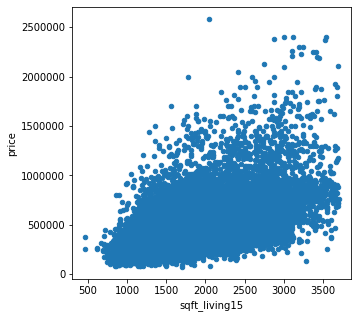

In [76]:
for col in df.columns:
    df.plot(kind='scatter',x=col,y='price', figsize=(5,5));
    plt.show()

*Due to the above scatterplots,and the definitions of the categories, I can deduce ['month_sold', 'condition', 'grade', and 'zipcode'] are all categorical

In [77]:
df.month_sold = df.month_sold.astype('category')
df.condition = df.condition.astype('category')
df.grade = df.grade.astype('category')
df.zipcode = df.zipcode.astype('category')

In [78]:
features = df.drop(columns='price') #rewriting this as I changed df categoricals
features.head()

,month_sold,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,last_constructed,zipcode,lat,long,sqft_living15
0,10,3,1.00,1180,5650,1.0,3,7,1955,1955,98178,47.5112,-122.257,1340
1,12,3,2.25,2570,7242,2.0,3,7,1951,1991,98125,47.7210,-122.319,1690
2,2,2,1.00,770,10000,1.0,3,6,1933,1933,98028,47.7379,-122.233,2720
3,12,4,3.00,1960,5000,1.0,5,7,1965,1965,98136,47.5208,-122.393,1360
4,2,3,2.00,1680,8080,1.0,3,8,1987,1987,98074,47.6168,-122.045,1800


In [79]:
features_cont = features.drop(columns=['month_sold', 'condition', 'grade', 'zipcode'])
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features_cont = scaler.fit_transform(features_cont)

In [80]:
for i in range(0,10):
    features_cont.iloc[:,i] = scaled_features_cont[:,i]

*Above I am scaling my continuous functions*

In [81]:
features_final = pd.concat([features_cont, features[['month_sold', 'condition', 'grade', 'zipcode']]], axis=1)

In [82]:
df = pd.concat([df['price'],features_final], axis=1)
df #combining the scaled features to the dataframe again

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,last_constructed,lat,long,sqft_living15,month_sold,condition,grade,zipcode
0,221900.0,-0.351733,-1.483019,-1.050273,-0.453125,-0.870234,-0.483097,-0.552986,-0.365468,-0.203500,-0.931393,10,3,7,98178
1,538000.0,-0.351733,0.333553,0.985694,-0.028047,0.971969,-0.616691,0.663746,1.159513,-0.674484,-0.304398,12,3,7,98125
2,180000.0,-1.501762,-1.483019,-1.650811,0.708362,-0.870234,-1.217868,-1.296545,1.282355,-0.021183,1.540758,2,3,6,98028
3,604000.0,0.798296,1.423496,0.092212,-0.626681,-0.870234,-0.149110,-0.215005,-0.295688,-1.236626,-0.895565,12,5,7,98136
4,510000.0,-0.351733,-0.029761,-0.317911,0.195706,-0.870234,0.585662,0.528554,0.402111,1.406961,-0.107343,2,3,8,98074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,-0.351733,0.696867,-0.537620,-1.659737,2.814172,1.320433,1.272112,1.001781,-0.879590,-0.591025,5,3,8,98103
21593,400000.0,0.798296,0.696867,0.604866,-0.409603,0.971969,1.487426,1.441103,-0.369102,-1.001134,-0.053600,2,3,8,98146
21594,402101.0,-1.501762,-1.846333,-1.284629,-1.601262,0.971969,1.320433,1.272112,0.239291,-0.522553,-1.504646,6,3,7,98144
21595,400000.0,-0.351733,0.696867,-0.435089,-1.324107,0.971969,1.153439,1.103122,-0.196106,1.224645,-0.805994,1,3,8,98027


**time for a little RFE**

In [83]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
target = df.price
linreg = LinearRegression()
# linreg.fit(features_final, target.values.ravel())

In [84]:
selector = RFE(linreg, n_features_to_select=4)
selector = selector.fit(features_final, target.values.ravel())

In [85]:
selector.ranking_

array([ 6,  5,  1,  8,  7,  1,  3,  1,  9,  2, 10,  4,  1, 11])

In [86]:
features_final.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'yr_built', 'last_constructed', 'lat', 'long', 'sqft_living15',
       'month_sold', 'condition', 'grade', 'zipcode'],
      dtype='object')

Most important are:
1. sqft_living
2. lat
3. grade
4. yr_built
5. sqft_living15
6. last_constructed
7. condition
8. bathrooms
9. bedrooms
10. floors
11. sqft_lot
12. long
13. month_sold
14. zipcode
*time to see how many of these variables to use*



In [87]:
R_squareds = []
for i in range(1,len(features_final.columns)+1):
    selector = RFE(linreg, n_features_to_select=i)
    selector.fit(features_final, target)
    linreg.fit(features_final[features_final.columns[selector.support_]], target)
    r_squared = linreg.score(features_final[features_final.columns[selector.support_]], target)
    R_squareds.append(r_squared)
R_squareds

[0.3412601651367094,
 0.4963271338102451,
 0.5517841072946974,
 0.6144594580925703,
 0.6210164031095644,
 0.6225288514813668,
 0.6269000804241552,
 0.6302520199964444,
 0.6340816695331616,
 0.6367913293683889,
 0.6379899528637496,
 0.6386012890419939,
 0.6401301658930492,
 0.6422806220163815]

*This says the improvement moves up quickest from 3 to 4 features. But my categoricals still should be hot-coded let's see what we can find.*


In [107]:
df.describe().round(3)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,last_constructed,lat,long,sqft_living15
count,18470.000,18470.000,18470.000,18470.000,18470.000,18470.000,18470.000,18470.000,18470.000,18470.000,18470.000
mean,483713.671,-0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000
std,249969.435,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,78000.000,-2.652,-2.210,-2.237,-1.823,-0.870,-2.320,-2.412,-2.948,-2.072,-2.508
25%,310000.000,-0.352,-0.756,-0.772,-0.680,-0.870,-0.650,-0.654,-0.623,-0.811,-0.752
50%,429000.000,-0.352,-0.030,-0.127,-0.039,-0.870,0.018,0.089,0.079,-0.287,-0.179
75%,595000.000,0.798,0.697,0.663,0.520,0.972,0.886,0.900,0.859,0.579,0.608
max,2580000.000,6.548,5.420,2.641,3.847,3.735,1.521,1.475,1.571,6.952,3.296


In [88]:
import statsmodels.formula.api as smf
#Below I included 4 continuous features plus the categoricals
f = 'price~month_sold+condition+grade+zipcode+sqft_living+lat+yr_built+sqft_living15'
model = smf.ols(formula=f, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     711.5
Date:                Thu, 31 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:38:59   Log-Likelihood:            -2.4145e+05
No. Observations:               18470   AIC:                         4.831e+05
Df Residuals:                   18373   BIC:                         4.838e+05
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         2.252e+05    1.2e+05      1.884      0.060   -9083.809    4.59e+05
month_sold[T.2]   2036.4761   5310.742      0.383      0.701   -8373.073    1.24e+04
month_sold[T.3]   1.795e+04   4915.132      3.652      0.000    8313.903    2.76e+04
month_sold[T.4]    2.95e+04   4786.787      6.164      0.000    2.01e+04    3.89e+04
month_sold[T.5]   -954.3968   4754.925     -0.201      0.841   -1.03e+04    8365.698
month_sold[T.6]  -6135.3570   4822.158     -1.272      0.203   -1.56e+04    3316.522
month_sold[T.7]  -7107.9060   4812.276     -1.477      0.140   -1.65e+04    2324.602
month_sold[T.8]  -1.291e+04   4900.735     -2.635      0.008   -2.25e+04   -3308.879
month_sold[T.9]  -1.446e+04   4977.899     -2.906      0.004   -2.42e+04   -4707.291
month_sold[T.10] -1.325e+04   4927.905     -2.689      0.007   -2.29e+04   -3589.534
month_sold[T.11] -1.152e+04   5190.783     -2.220      0.026   -2.17e+04   -1347.592
month_sold[T.12] -9987.1890   5157.793     -1.936      0.053   -2.01e+04     122.566
condition[T.2]    4.849e+04   2.67e+04      1.815      0.070   -3875.662    1.01e+05
condition[T.3]    7.617e+04   2.49e+04      3.059      0.002    2.74e+04    1.25e+05
condition[T.4]    9.694e+04   2.49e+04      3.890      0.000    4.81e+04    1.46e+05
condition[T.5]    1.332e+05    2.5e+04      5.318      0.000    8.41e+04    1.82e+05
grade[T.4]       -1.057e+05   1.19e+05     -0.889      0.374   -3.39e+05    1.27e+05
grade[T.5]       -1.127e+05   1.16e+05     -0.971      0.332    -3.4e+05    1.15e+05
grade[T.6]       -1.062e+05   1.16e+05     -0.916      0.360   -3.33e+05    1.21e+05
grade[T.7]       -8.174e+04   1.16e+05     -0.705      0.481   -3.09e+05    1.45e+05
grade[T.8]       -3.291e+04   1.16e+05     -0.284      0.777    -2.6e+05    1.94e+05
grade[T.9]        7.386e+04   1.16e+05      0.637      0.524   -1.54e+05    3.01e+05
grade[T.10]       1.932e+05   1.16e+05      1.664      0.096   -3.44e+04    4.21e+05
grade[T.11]       3.192e+05   1.17e+05      2.726      0.006    8.97e+04    5.49e+05
zipcode[T.98002]  1.278e+04   1.06e+04      1.207      0.227   -7968.838    3.35e+04
zipcode[T.98003]  2412.7379   9729.719      0.248      0.804   -1.67e+04    2.15e+04
zipcode[T.98004]  6.491e+05   1.96e+04     33.179      0.000    6.11e+05    6.87e+05
zipcode[T.98005]  3.533e+05   2.03e+04     17.415      0.000    3.14e+05    3.93e+05
zipcode[T.98006]  2.889e+05   1.63e+04     17.703      0.000    2.57e+05    3.21e+05
zipcode[T.98007]  2.718e+05   2.04e+04     13.352      0.000    2.32e+05    3.12e+05
zipcode[T.98008]  2.967e+05   1.92e+04     15.416      0.000    2.59e+05    3.34e+05
zipcode[T.98010]  9.807e+04   1.72e+04      5.694      0.000    6.43e+04    1.32e+05
zipcode[T.98011]  1.992e+05   2.66e+04      7.479      0.000    1.47e+05    2.51e+05
zipcode[T.98014]  1.772

*Let's see what happens if I break up the data!*

In [89]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'yr_built', 'last_constructed', 'lat', 'long', 'sqft_living15',
       'month_sold', 'condition', 'grade', 'zipcode'],
      dtype='object')

In [90]:
df_reno = df[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'last_constructed', 'month_sold', 'condition', 'grade']]

In [91]:
df_cant_reno = df[['price', 'sqft_lot', 'yr_built', 'lat', 'long', 'sqft_living15', 'zipcode']]

*df_reno has items I can change/renovate plus price. df_cant_reno has the more permanent items I can't control for plus price*

In [109]:
#using categoricals plus 4 most important of the features I can influence
f_reno = 'price~C(month_sold)+C(condition)+C(grade)+sqft_living+last_constructed+bathrooms'
model_reno = smf.ols(formula=f_reno, data=df_reno).fit()
model_reno.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     777.4
Date:                Thu, 31 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:44:39   Log-Likelihood:            -2.4894e+05
No. Observations:               18470   AIC:                         4.979e+05
Df Residuals:                   18443   BIC:                         4.981e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            2.517e+05   1.77e+05      1.422      0.155   -9.52e+04    5.99e+05
C(month_sold)[T.2]   5518.9745   7939.124      0.695      0.487      -1e+04    2.11e+04
C(month_sold)[T.3]    2.86e+04   7347.201      3.893      0.000    1.42e+04     4.3e+04
C(month_sold)[T.4]   3.928e+04   7152.469      5.492      0.000    2.53e+04    5.33e+04
C(month_sold)[T.5]   1.851e+04   7104.267      2.605      0.009    4582.693    3.24e+04
C(month_sold)[T.6]   7502.2206   7205.449      1.041      0.298   -6621.126    2.16e+04
C(month_sold)[T.7]   7445.7640   7190.742      1.035      0.300   -6648.757    2.15e+04
C(month_sold)[T.8]   2364.7890   7324.344      0.323      0.747    -1.2e+04    1.67e+04
C(month_sold)[T.9]  -1239.6613   7440.870     -0.167      0.868   -1.58e+04    1.33e+04
C(month_sold)[T.10]  2385.1551   7364.687      0.324      0.746   -1.21e+04    1.68e+04
C(month_sold)[T.11]  -537.2051   7757.639     -0.069      0.945   -1.57e+04    1.47e+04
C(month_sold)[T.12] -3215.7063   7711.602     -0.417      0.677   -1.83e+04    1.19e+04
C(condition)[T.2]   -5.001e+04   3.99e+04     -1.254      0.210   -1.28e+05    2.81e+04
C(condition)[T.3]   -4283.3798   3.71e+04     -0.115      0.908   -7.71e+04    6.85e+04
C(condition)[T.4]    3646.8785   3.71e+04      0.098      0.922   -6.92e+04    7.65e+04
C(condition)[T.5]    4.389e+04   3.73e+04      1.176      0.240   -2.93e+04    1.17e+05
C(grade)[T.4]        1.153e+04   1.77e+05      0.065      0.948   -3.36e+05    3.59e+05
C(grade)[T.5]       -1838.6327   1.73e+05     -0.011      0.992   -3.42e+05    3.38e+05
C(grade)[T.6]         5.74e+04   1.73e+05      0.332      0.740   -2.82e+05    3.96e+05
C(grade)[T.7]        1.482e+05   1.73e+05      0.857      0.392   -1.91e+05    4.87e+05
C(grade)[T.8]        2.711e+05   1.73e+05      1.567      0.117    -6.8e+04     6.1e+05
C(grade)[T.9]        4.479e+05   1.73e+05      2.588      0.010    1.09e+05    7.87e+05
C(grade)[T.10]       6.139e+05   1.73e+05      3.544      0.000    2.74e+05    9.53e+05
C(grade)[T.11]       7.741e+05   1.75e+05      4.432      0.000    4.32e+05    1.12e+06
sqft_living          6.677e+04   2064.201     32.346      0.000    6.27e+04    7.08e+04
last_constructed    -8.392e+04   1731.444    -48.468      0.000   -8.73e+04   -8.05e+04
bathrooms            2.715e+04   2059.261     13.185      0.000    2.31e+04    3.12e+04
==============================================================================
Omnibus:                     6468.105   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46655.850
Skew:                           1.498   Prob(JB):                         0.00
Kurtosis:                      10.187   Cond. No.                         604.
================================================

*R2 went down :( Next try the ones I don't have control over*

In [93]:
f_cant_reno = 'price~zipcode+lat+yr_built+sqft_living15+sqft_lot'
model_cant = smf.ols(formula=f_cant_reno, data=df_cant_reno).fit()
model_cant.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     512.9
Date:                Thu, 31 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:39:00   Log-Likelihood:            -2.4552e+05
No. Observations:               18470   AIC:                         4.912e+05
Df Residuals:                   18396   BIC:                         4.918e+05
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         2.088e+05    1.9e+04     11.007      0.000    1.72e+05    2.46e+05
zipcode[T.98002]  5.873e+04   1.32e+04      4.456      0.000    3.29e+04    8.46e+04
zipcode[T.98003]  1.559e+04   1.21e+04      1.289      0.198   -8124.453    3.93e+04
zipcode[T.98004]  6.719e+05   2.43e+04     27.619      0.000    6.24e+05     7.2e+05
zipcode[T.98005]  4.006e+05   2.52e+04     15.883      0.000    3.51e+05     4.5e+05
zipcode[T.98006]  3.497e+05   2.03e+04     17.256      0.000     3.1e+05    3.89e+05
zipcode[T.98007]  3.341e+05   2.53e+04     13.200      0.000    2.85e+05    3.84e+05
zipcode[T.98008]  3.457e+05   2.39e+04     14.440      0.000    2.99e+05    3.93e+05
zipcode[T.98010]   9.12e+04   2.14e+04      4.260      0.000    4.92e+04    1.33e+05
zipcode[T.98011]   2.22e+05   3.31e+04      6.698      0.000    1.57e+05    2.87e+05
zipcode[T.98014]  1.652e+05   3.36e+04      4.912      0.000    9.93e+04    2.31e+05
zipcode[T.98019]  1.535e+05   3.24e+04      4.731      0.000    8.99e+04    2.17e+05
zipcode[T.98022]  1.781e+04   1.61e+04      1.104      0.270   -1.38e+04    4.94e+04
zipcode[T.98023] -6916.0959   1.06e+04     -0.655      0.513   -2.76e+04    1.38e+04
zipcode[T.98024]   2.11e+05   3.49e+04      6.048      0.000    1.43e+05    2.79e+05
zipcode[T.98027]  2.898e+05   1.99e+04     14.545      0.000    2.51e+05    3.29e+05
zipcode[T.98028]   2.09e+05   3.26e+04      6.415      0.000    1.45e+05    2.73e+05
zipcode[T.98029]  3.148e+05   2.07e+04     15.190      0.000    2.74e+05    3.55e+05
zipcode[T.98030]  2.262e+04    1.3e+04      1.743      0.081   -2816.969    4.81e+04
zipcode[T.98031]   3.52e+04   1.38e+04      2.559      0.011    8234.890    6.22e+04
zipcode[T.98032]  3.205e+04   1.62e+04      1.984      0.047     391.301    6.37e+04
zipcode[T.98033]   4.41e+05   2.76e+04     16.001      0.000    3.87e+05    4.95e+05
zipcode[T.98034]  2.899e+05   2.98e+04      9.732      0.000    2.32e+05    3.48e+05
zipcode[T.98038]  4.406e+04   1.11e+04      3.960      0.000    2.23e+04    6.59e+04
zipcode[T.98039]  9.728e+05   3.79e+04     25.699      0.000    8.99e+05    1.05e+06
zipcode[T.98040]  5.566e+05   2.16e+04     25.773      0.000    5.14e+05    5.99e+05
zipcode[T.98042]  2.541e+04   1.13e+04      2.243      0.025    3201.888    4.76e+04
zipcode[T.98045]  1.301e+05   1.83e+04      7.125      0.000    9.43e+04    1.66e+05
zipcode[T.98052]  3.377e+05   2.71e+04     12.468      0.000    2.85e+05    3.91e+05
zipcode[T.98053]  3.446e+05   2.91e+04     11.831      0.000    2.88e+05    4.02e+05
zipcode[T.98055]  8.761e+04   1.59e+04      5.526      0.000    5.65e+04    1.19e+05
zipcode[T.98056]  1.711e+05   1.75e+04      9.793      0.000    1.37e+05    2.05e+05
zipcode[T.98058]  7.327e+04   1.44e+04      5.087      0.000     4.5e+04    1.02e+05
zipcode[T.98059]  1.214

In [94]:
print(f'Model1 total High Pvalues: {sum(np.abs(model.pvalues) > .05)}\n')
print(f'Model_reno total High Pvalues: {sum(np.abs(model_reno.pvalues) > .05)}\n') 
print(f'Model_cant_reno total High Pvalues: {sum(np.abs(model_cant.pvalues) > .05)}\n')

Model1 total High Pvalues: 20

Model_reno total High Pvalues: 22

Model_cant_reno total High Pvalues: 5



R2 decreased with items I have control over, but increased for what I don't control(still less than overall model.
What' I can't control also has the fewest high p-values

In [95]:
f = 'price~zipcode+sqft_living+lat+sqft_lot+yr_built+sqft_living15'
model = smf.ols(formula=f, data=df).fit()
display(sum(np.abs(model.pvalues) > .05))
model.summary()

6

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     751.1
Date:                Thu, 31 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:39:01   Log-Likelihood:            -2.4292e+05
No. Observations:               18470   AIC:                         4.860e+05
Df Residuals:                   18395   BIC:                         4.866e+05
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         2.309e+05   1.65e+04     14.013      0.000    1.99e+05    2.63e+05
zipcode[T.98002]  3.357e+04   1.15e+04      2.930      0.003    1.11e+04     5.6e+04
zipcode[T.98003]  1.487e+04   1.05e+04      1.415      0.157   -5733.041    3.55e+04
zipcode[T.98004]  6.826e+05   2.11e+04     32.297      0.000    6.41e+05    7.24e+05
zipcode[T.98005]  3.794e+05   2.19e+04     17.313      0.000    3.36e+05    4.22e+05
zipcode[T.98006]  3.359e+05   1.76e+04     19.080      0.000    3.01e+05     3.7e+05
zipcode[T.98007]  3.119e+05    2.2e+04     14.180      0.000    2.69e+05    3.55e+05
zipcode[T.98008]   3.23e+05   2.08e+04     15.529      0.000    2.82e+05    3.64e+05
zipcode[T.98010]  9.878e+04   1.86e+04      5.311      0.000    6.23e+04    1.35e+05
zipcode[T.98011]  2.083e+05   2.88e+04      7.233      0.000    1.52e+05    2.65e+05
zipcode[T.98014]  1.681e+05   2.92e+04      5.755      0.000    1.11e+05    2.25e+05
zipcode[T.98019]  1.458e+05   2.82e+04      5.171      0.000    9.05e+04    2.01e+05
zipcode[T.98022]  1.938e+04    1.4e+04      1.382      0.167   -8102.710    4.69e+04
zipcode[T.98023] -9740.3328   9178.187     -1.061      0.289   -2.77e+04    8249.768
zipcode[T.98024]  1.868e+05   3.03e+04      6.164      0.000    1.27e+05    2.46e+05
zipcode[T.98027]  2.788e+05   1.73e+04     16.107      0.000    2.45e+05    3.13e+05
zipcode[T.98028]  1.973e+05   2.83e+04      6.971      0.000    1.42e+05    2.53e+05
zipcode[T.98029]  3.004e+05    1.8e+04     16.685      0.000    2.65e+05    3.36e+05
zipcode[T.98030]  1.735e+04   1.13e+04      1.539      0.124   -4743.024    3.95e+04
zipcode[T.98031]  3.225e+04    1.2e+04      2.699      0.007    8828.058    5.57e+04
zipcode[T.98032]   2.39e+04    1.4e+04      1.703      0.089   -3608.417    5.14e+04
zipcode[T.98033]  4.213e+05   2.39e+04     17.593      0.000    3.74e+05    4.68e+05
zipcode[T.98034]  2.736e+05   2.59e+04     10.570      0.000    2.23e+05    3.24e+05
zipcode[T.98038]  4.423e+04   9665.770      4.576      0.000    2.53e+04    6.32e+04
zipcode[T.98039]  9.827e+05   3.29e+04     29.881      0.000    9.18e+05    1.05e+06
zipcode[T.98040]  5.445e+05   1.88e+04     29.017      0.000    5.08e+05    5.81e+05
zipcode[T.98042]  2.735e+04   9844.521      2.778      0.005    8050.381    4.66e+04
zipcode[T.98045]  1.352e+05   1.59e+04      8.525      0.000    1.04e+05    1.66e+05
zipcode[T.98052]  3.204e+05   2.35e+04     13.613      0.000    2.74e+05    3.67e+05
zipcode[T.98053]  3.316e+05   2.53e+04     13.104      0.000    2.82e+05    3.81e+05
zipcode[T.98055]  7.723e+04   1.38e+04      5.607      0.000    5.02e+04    1.04e+05
zipcode[T.98056]  1.517e+05   1.52e+04      9.993      0.000    1.22e+05    1.81e+05
zipcode[T.98058]  6.327e+04   1.25e+04      5.056      0.000    3.87e+04    8.78e+04
zipcode[T.98059]   1.11

*using just zipcodes in my original model(that was the only categorical value for my cant_reno model which had the fewest pvalues.....pvalues drop to 5, but my R2 dropped a little bit to .749

In [96]:
f_reno = 'price~zipcode+sqft_living+last_constructed+condition+bathrooms'
model_reno = smf.ols(formula=f_reno, data=df).fit()
display(sum(np.abs(model_reno.pvalues) > .05))
model_reno.summary()

11

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     684.2
Date:                Thu, 31 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:39:01   Log-Likelihood:            -2.4338e+05
No. Observations:               18470   AIC:                         4.869e+05
Df Residuals:                   18393   BIC:                         4.875e+05
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         2.045e+05   2.84e+04      7.203      0.000    1.49e+05     2.6e+05
zipcode[T.98002]  2709.0450   1.17e+04      0.231      0.817   -2.03e+04    2.57e+04
zipcode[T.98003]  1.513e+04   1.08e+04      1.404      0.160   -5985.129    3.62e+04
zipcode[T.98004]  6.737e+05   1.14e+04     58.898      0.000    6.51e+05    6.96e+05
zipcode[T.98005]  3.515e+05   1.39e+04     25.289      0.000    3.24e+05    3.79e+05
zipcode[T.98006]  3.178e+05   9945.690     31.952      0.000    2.98e+05    3.37e+05
zipcode[T.98007]  2.681e+05   1.33e+04     20.100      0.000    2.42e+05    2.94e+05
zipcode[T.98008]  2.745e+05   1.08e+04     25.413      0.000    2.53e+05    2.96e+05
zipcode[T.98010]  9.347e+04    1.9e+04      4.907      0.000    5.61e+04    1.31e+05
zipcode[T.98011]  1.502e+05   1.21e+04     12.465      0.000    1.27e+05    1.74e+05
zipcode[T.98014]  1.118e+05   1.99e+04      5.626      0.000    7.28e+04    1.51e+05
zipcode[T.98019]  8.968e+04    1.3e+04      6.920      0.000    6.43e+04    1.15e+05
zipcode[T.98022]  2.254e+04   1.28e+04      1.760      0.078   -2568.614    4.77e+04
zipcode[T.98023] -7658.7779   9407.903     -0.814      0.416   -2.61e+04    1.08e+04
zipcode[T.98024]  1.419e+05   2.71e+04      5.227      0.000    8.87e+04    1.95e+05
zipcode[T.98027]  2.411e+05    1.1e+04     21.856      0.000     2.2e+05    2.63e+05
zipcode[T.98028]   1.39e+05   1.08e+04     12.838      0.000    1.18e+05     1.6e+05
zipcode[T.98029]  2.521e+05   1.05e+04     24.002      0.000    2.32e+05    2.73e+05
zipcode[T.98030]  6181.3362    1.1e+04      0.563      0.574   -1.54e+04    2.77e+04
zipcode[T.98031]  1.233e+04   1.09e+04      1.135      0.256   -8953.506    3.36e+04
zipcode[T.98032]  5472.6180   1.39e+04      0.394      0.693   -2.17e+04    3.27e+04
zipcode[T.98033]  3.658e+05   9895.025     36.973      0.000    3.46e+05    3.85e+05
zipcode[T.98034]  2.049e+05   9221.310     22.215      0.000    1.87e+05    2.23e+05
zipcode[T.98038]  3.226e+04   9331.901      3.457      0.001     1.4e+04    5.06e+04
zipcode[T.98039]   9.97e+05   2.77e+04     35.981      0.000    9.43e+05    1.05e+06
zipcode[T.98040]  5.403e+05   1.18e+04     45.716      0.000    5.17e+05    5.63e+05
zipcode[T.98042]  9915.0577   9477.917      1.046      0.296   -8662.542    2.85e+04
zipcode[T.98045]  1.151e+05   1.29e+04      8.890      0.000    8.97e+04     1.4e+05
zipcode[T.98052]  2.727e+05   9250.653     29.474      0.000    2.55e+05    2.91e+05
zipcode[T.98053]  2.601e+05   1.14e+04     22.893      0.000    2.38e+05    2.82e+05
zipcode[T.98055]  4.723e+04   1.08e+04      4.363      0.000     2.6e+04    6.85e+04
zipcode[T.98056]  1.057e+05   9842.234     10.741      0.000    8.64e+04    1.25e+05
zipcode[T.98058]   4.02e+04   9765.582      4.117      0.000    2.11e+04    5.93e+04
zipcode[T.98059]  9.008

*zipcode is valuable as it also dropped pvalues and brought R2 up for my can_reno model. While zipcode does have pvalues, it helps with R2 as shown with my original model below w/o zipcode*

In [97]:
f = 'price~zipcode+sqft_living+lat+yr_built+sqft_living15'
model = smf.ols(formula=f, data=df).fit()
display(sum(np.abs(model.pvalues) > .05))
model.summary()

5

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     752.6
Date:                Thu, 31 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:39:02   Log-Likelihood:            -2.4300e+05
No. Observations:               18470   AIC:                         4.862e+05
Df Residuals:                   18396   BIC:                         4.867e+05
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         2.422e+05   1.65e+04     14.655      0.000     2.1e+05    2.75e+05
zipcode[T.98002]  2.378e+04   1.15e+04      2.071      0.038    1276.251    4.63e+04
zipcode[T.98003]  1.291e+04   1.06e+04      1.223      0.221   -7784.192    3.36e+04
zipcode[T.98004]  6.845e+05   2.12e+04     32.243      0.000    6.43e+05    7.26e+05
zipcode[T.98005]  3.816e+05    2.2e+04     17.341      0.000    3.38e+05    4.25e+05
zipcode[T.98006]  3.354e+05   1.77e+04     18.967      0.000    3.01e+05     3.7e+05
zipcode[T.98007]  3.068e+05   2.21e+04     13.891      0.000    2.64e+05     3.5e+05
zipcode[T.98008]  3.173e+05   2.09e+04     15.193      0.000    2.76e+05    3.58e+05
zipcode[T.98010]  1.054e+05   1.87e+04      5.646      0.000    6.88e+04    1.42e+05
zipcode[T.98011]  2.042e+05   2.89e+04      7.059      0.000    1.47e+05    2.61e+05
zipcode[T.98014]  1.826e+05   2.93e+04      6.229      0.000    1.25e+05     2.4e+05
zipcode[T.98019]  1.455e+05   2.83e+04      5.139      0.000       9e+04    2.01e+05
zipcode[T.98022]  1.602e+04   1.41e+04      1.138      0.255   -1.16e+04    4.36e+04
zipcode[T.98023] -1.327e+04   9214.365     -1.440      0.150   -3.13e+04    4791.942
zipcode[T.98024]  1.922e+05   3.04e+04      6.314      0.000    1.33e+05    2.52e+05
zipcode[T.98027]  2.664e+05   1.74e+04     15.346      0.000    2.32e+05       3e+05
zipcode[T.98028]  1.961e+05   2.84e+04      6.898      0.000     1.4e+05    2.52e+05
zipcode[T.98029]  2.834e+05    1.8e+04     15.717      0.000    2.48e+05    3.19e+05
zipcode[T.98030]  1.247e+04   1.13e+04      1.102      0.271   -9711.700    3.47e+04
zipcode[T.98031]  2.708e+04    1.2e+04      2.258      0.024    3569.437    5.06e+04
zipcode[T.98032]  2.048e+04   1.41e+04      1.453      0.146   -7148.527    4.81e+04
zipcode[T.98033]  4.158e+05    2.4e+04     17.290      0.000    3.69e+05    4.63e+05
zipcode[T.98034]  2.689e+05    2.6e+04     10.342      0.000    2.18e+05     3.2e+05
zipcode[T.98038]  3.403e+04   9675.073      3.517      0.000    1.51e+04     5.3e+04
zipcode[T.98039]  9.928e+05    3.3e+04     30.064      0.000    9.28e+05    1.06e+06
zipcode[T.98040]  5.459e+05   1.88e+04     28.965      0.000    5.09e+05    5.83e+05
zipcode[T.98042]  2.168e+04   9877.775      2.195      0.028    2322.869     4.1e+04
zipcode[T.98045]  1.414e+05   1.59e+04      8.879      0.000     1.1e+05    1.73e+05
zipcode[T.98052]  3.145e+05   2.36e+04     13.308      0.000    2.68e+05    3.61e+05
zipcode[T.98053]  3.202e+05   2.54e+04     12.608      0.000     2.7e+05     3.7e+05
zipcode[T.98055]  6.653e+04   1.38e+04      4.817      0.000    3.95e+04    9.36e+04
zipcode[T.98056]  1.441e+05   1.52e+04      9.460      0.000    1.14e+05    1.74e+05
zipcode[T.98058]  5.897e+04   1.26e+04      4.693      0.000    3.43e+04    8.36e+04
zipcode[T.98059]   1.07

In [98]:
df.corrwith(df['price']).abs().sort_values(ascending=False)

price               1.000000
sqft_living         0.584175
sqft_living15       0.518544
bathrooms           0.405424
lat                 0.404888
bedrooms            0.266657
floors              0.235849
sqft_lot            0.030844
yr_built            0.025972
long                0.025226
last_constructed    0.024910
dtype: float64

In [99]:
f_final = 'price~zipcode+sqft_living+lat+long+sqft_living15' #got long after playing with numbers
model_final = smf.ols(formula=f_final, data=df).fit()
display(sum(np.abs(model_final.pvalues) > .05))
model_final.summary()

3

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     747.9
Date:                Thu, 31 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:39:02   Log-Likelihood:            -2.4305e+05
No. Observations:               18470   AIC:                         4.862e+05
Df Residuals:                   18396   BIC:                         4.868e+05
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         2.273e+05   1.68e+04     13.554      0.000    1.94e+05     2.6e+05
zipcode[T.98002]  3.783e+04   1.18e+04      3.214      0.001    1.48e+04    6.09e+04
zipcode[T.98003]  8284.3908   1.07e+04      0.772      0.440   -1.28e+04    2.93e+04
zipcode[T.98004]  7.081e+05   2.16e+04     32.732      0.000    6.66e+05    7.51e+05
zipcode[T.98005]  4.101e+05   2.27e+04     18.046      0.000    3.66e+05    4.55e+05
zipcode[T.98006]  3.637e+05   1.88e+04     19.378      0.000    3.27e+05    4.01e+05
zipcode[T.98007]  3.376e+05   2.31e+04     14.591      0.000    2.92e+05    3.83e+05
zipcode[T.98008]  3.541e+05   2.24e+04     15.828      0.000     3.1e+05    3.98e+05
zipcode[T.98010]  1.514e+05   2.19e+04      6.914      0.000    1.09e+05    1.94e+05
zipcode[T.98011]   2.23e+05   2.94e+04      7.596      0.000    1.65e+05     2.8e+05
zipcode[T.98014]  2.667e+05   3.68e+04      7.251      0.000    1.95e+05    3.39e+05
zipcode[T.98019]  1.994e+05   3.22e+04      6.191      0.000    1.36e+05    2.62e+05
zipcode[T.98022]  6.453e+04   1.86e+04      3.477      0.001    2.82e+04    1.01e+05
zipcode[T.98023] -2.741e+04   1.02e+04     -2.699      0.007   -4.73e+04   -7503.205
zipcode[T.98024]  2.663e+05   3.51e+04      7.585      0.000    1.97e+05    3.35e+05
zipcode[T.98027]  3.036e+05   2.03e+04     14.983      0.000    2.64e+05    3.43e+05
zipcode[T.98028]  2.082e+05   2.86e+04      7.278      0.000    1.52e+05    2.64e+05
zipcode[T.98029]  3.265e+05   2.21e+04     14.755      0.000    2.83e+05     3.7e+05
zipcode[T.98030]  2.573e+04    1.2e+04      2.151      0.032    2279.758    4.92e+04
zipcode[T.98031]   4.19e+04   1.27e+04      3.310      0.001    1.71e+04    6.67e+04
zipcode[T.98032]  2.558e+04   1.41e+04      1.812      0.070   -2084.471    5.33e+04
zipcode[T.98033]  4.379e+05   2.46e+04     17.795      0.000     3.9e+05    4.86e+05
zipcode[T.98034]  2.873e+05   2.64e+04     10.886      0.000    2.36e+05    3.39e+05
zipcode[T.98038]  6.913e+04   1.45e+04      4.768      0.000    4.07e+04    9.76e+04
zipcode[T.98039]  1.015e+06   3.32e+04     30.569      0.000    9.49e+05    1.08e+06
zipcode[T.98040]  5.653e+05   1.91e+04     29.630      0.000    5.28e+05    6.03e+05
zipcode[T.98042]  4.603e+04   1.22e+04      3.782      0.000    2.22e+04    6.99e+04
zipcode[T.98045]  2.271e+05   2.81e+04      8.075      0.000    1.72e+05    2.82e+05
zipcode[T.98052]  3.448e+05    2.5e+04     13.803      0.000    2.96e+05    3.94e+05
zipcode[T.98053]  3.589e+05   2.82e+04     12.713      0.000    3.04e+05    4.14e+05
zipcode[T.98055]  8.435e+04   1.43e+04      5.909      0.000    5.64e+04    1.12e+05
zipcode[T.98056]  1.639e+05   1.59e+04     10.280      0.000    1.33e+05    1.95e+05
zipcode[T.98058]  8.264e+04   1.39e+04      5.962      0.000    5.55e+04     1.1e+05
zipcode[T.98059]  1.297

In [100]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_final, target)

In [101]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [102]:
yhat_train = linreg.predict(X_train)
yhat_test = linreg.predict(X_test)

In [103]:
from sklearn.metrics import mean_squared_error

In [104]:
train_mse = mean_squared_error(y_train, yhat_train)
test_mse = mean_squared_error(y_test, yhat_test)
display(train_mse**.5, test_mse**.5)

147906.7168794516

154346.4053178974

# CONCLUSIONS & RECOMMENDATIONS

## What's more important? Factors when considering where to buy your house or the renovations?
Seems as if the factors when purchasing the house, appear to be most revelant to house prices. However, there is too much of a difference from those features and our actual price to account for all price changes.

## What is the most revelant feature you can change? Most revelent one you can't change?
The sqft_living appears to have a strong affect on the price. The one I can't change but has a huge affect is zipcode.
-bullit point list of most important factors
-at least 3 features(also into non tech)
